In [11]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter
from joblib import Parallel, delayed

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [3]:
sn = read_snap(500, 0, parttype=2)

In [17]:
def compute_A_BXP(sn, Rmin=1, Rmax=2, center=np.array([0., 0., 0.])):
    pos = sn.part2.pos.value - center
    
    mass = sn.MassTable[2]
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    key = np.logical_and(R < Rmax, R > Rmin)
    
    ans = np.sum(np.square(pos[:,2][key]))
    ans /= len(np.where(key)[0])
    
    return np.sqrt(ans)
    
def to_parallelize(i):
    snN = read_snap(i, 0, parttype=2)
    snS = read_snap(i, 1, parttype=2)
    
    ans_N = compute_A_BXP(snN)
    ans_S = compute_A_BXP(snS, center=np.array([200., 200., 200.]))
    
    t = snN.Time.value
    
    return t, ans_N, ans_S

In [18]:
ans = Parallel(n_jobs=32) (delayed(to_parallelize)(i) for i in tqdm(np.arange(0, 1599, 20)))

A Jupyter Widget

In [20]:
ans = np.array(ans)

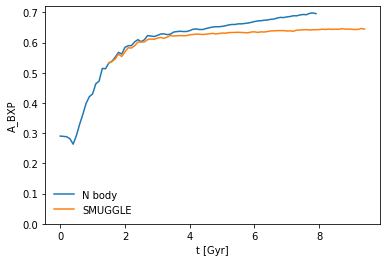

In [27]:

plt.plot(ans[:,0], ans[:,1], label='N body')
plt.plot(ans[:,0] + ans[:,0][300//20], ans[:,2], label='SMUGGLE')

plt.ylim(0, None)

plt.xlabel('t [Gyr]')
plt.ylabel('A_BXP')

plt.legend(frameon=False)

plt.show()